In [1]:
%matplotlib inline

import numpy as np
from tqdm import tqdm

In [10]:
import pickle

gpr_model = pickle.load(open("gprMatern0.66.dump","rb"))
normalizer = lambda X: (X - [103.16726412, 103.05644853, 122.86389106] )/ [3.54492885, 3.87407133, 3.28592364]
func = lambda currents: gpr_model.predict(normalizer(currents.reshape(1, -1)))[0]
func(np.array([110,110,120]))

42.23986794972206

In [11]:
class Venus:
    def __init__(
        self,
        inj_limits=[97, 110],
        mid_limits=[97, 110],
        ext_limits=[116, 128],
        beam_range=[0.50, 1.00],
        jitter=0
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )

    def _rescale_output(self, output):
        """simple square returns values betwen 0 and 27 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 27.0) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return func(self.currents)

    @staticmethod
    def _simple_square(w, x, y):
        """A not so funky 3 dimensional parameter space with a single minima."""
        return (
            (w - 3.)**2 + (x - 3.)**2 + (y - 3.)**2
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [18]:
venus = Venus(jitter=0.15)

set the currents and read the beam value

In [19]:
venus.set_mag_currents(100, 100, 120)
bc = venus.get_beam_current()
print(bc)

99.8081477254076


if currents are outside the range a `ValueError` is raised and can be captured.

In [20]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

# Bayesian Optimization

In [32]:
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 29)
optimizer.maximize(init_points = 5, n_iter = 20, kappa=2.3, alpha=0.15)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        |  29.78    |  108.2    |  100.7    |  116.9    |
|  2        |  75.98    |  106.9    |  102.9    |  122.5    |
|  3        |  116.3    |  106.4    |  108.0    |  125.2    |
|  4        |  94.33    |  106.5    |  100.1    |  124.6    |
|  5        |  100.2    |  97.76    |  102.3    |  123.3    |
|  6        |  62.41    |  101.1    |  109.1    |  128.0    |
|  7        |  86.73    |  102.8    |  108.4    |  122.6    |
|  8        |  118.2    |  105.8    |  104.6    |  127.8    |
|  9        |  98.57    |  110.0    |  106.8    |  128.0    |
|  10       |  81.35    |  101.9    |  99.82    |  128.0    |
|  11       |  58.25    |  110.0    |  109.9    |  123.4    |
|  12       |  89.23    |  106.7    |  107.1    |  127.4    |
|  13       |  134.4    |  105.6    |  105.0    |  126.5    |
|  14       |  125.1    |  104.9    |  105.8    |  125.2    |
|  15   

In [76]:
import random
# try a certain times and see how many converges
CUTOFF = 140
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
    noise = 0.15 # max(venus.get_noise_level(), 1e-5)
    print(noise)

    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    
    plt.scatter([coords[i]['A'] for i in range(len(coords))], [coords[i]['B'] for i in range(len(coords))]) #, [coords[i]['C'] for i in range(len(coords))]
    plt.xlim(pbounds['A'][0], pbounds['A'][1])
    plt.ylim(pbounds['B'][0], pbounds['B'][1])
    # ax.set_zlim3d(pbounds['C'][0], pbounds['C'][1])
    
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))   
def trial2(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
    noise = max(venus.get_noise_level(), 1e-5)
    
    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    # print("Results:", results)
    n_succ = sum([i>=CUTOFF for i in results]) / len(results)
    return n_succ, results

In [77]:
trial2(10, n_iter = 10, init_points = 5, kappa = 2.3, verbose = 0)

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


(0.5,
 [147.4129058276512,
  143.5620131795363,
  146.14358768915133,
  126.84981855360957,
  119.28674503077718,
  144.60193154615962,
  142.73191648634278,
  135.57971237824646,
  131.09419034711007,
  122.98740714304493])

In [78]:
succ_rates = []
results_list = []
kappas = np.linspace(0.1, 5, 3)
for kappa in kappas:
    succ_rate, results = trial2(30, n_iter = 10, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    results_list.append(results)

100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


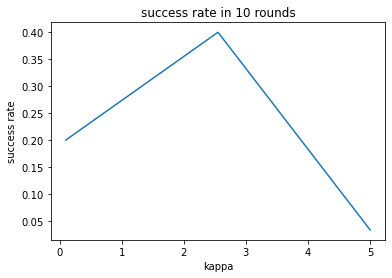

In [80]:
plt.plot(kappas, succ_rates)
plt.xlabel("kappa")
plt.ylabel("success rate")
plt.title("success rate in 10 rounds")
plt.savefig("10 trial succ_rate.png")
plt.show()

100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


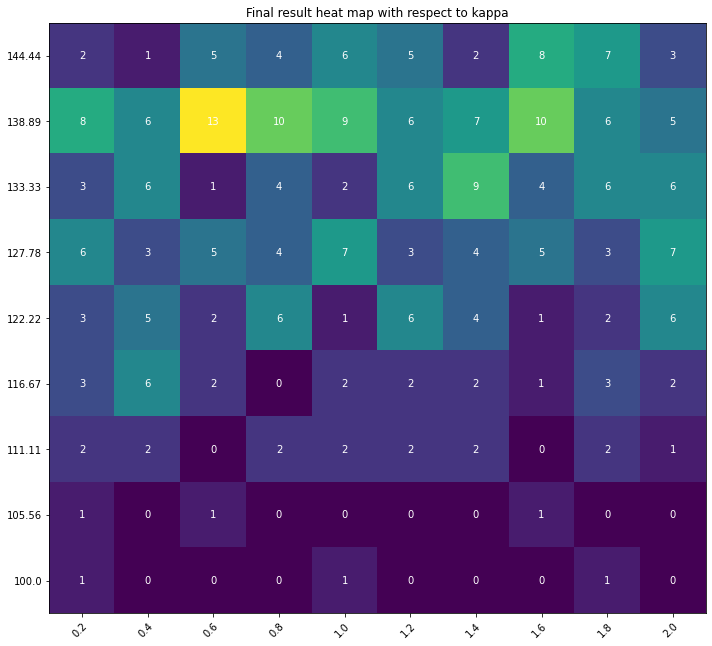

In [141]:
succ_rates = []
results_list = []
kappas = np.linspace(0.2, 2, 10)
for kappa in kappas:
    succ_rate, results = trial2(30, n_iter = 10, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    results_list.append(results)

MIN = 100
MAX = 150
hist_bin = list(np.linspace(MIN, MAX, 10))
hist_list = []
for results in results_list:
    hist, bins = np.histogram(results, bins=hist_bin)
    hist_list.append(hist)
hist_results = np.vstack(hist_list).T[::-1]
hist_bin = [round(h,2) for h in hist_bin][:-1][::-1] # data manipulation for plots

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(hist_results)

# avg_list = [(sum(results)/len(results)-MIN)/(MAX-MIN) for results in results_list]
# print(avg_list)
# ax.plot(avg_list, color="red")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(kappas)))
ax.set_xticklabels([round(k,2) for k in kappas])
ax.set_yticks(np.arange(len(hist_bin)))
ax.set_yticklabels(hist_bin)
# ax.set_xticks(np.arange(len(kappas)), labels=kappas)
# ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(hist_bin)):
    for j in range(len(kappas)):
        text = ax.text(j, i, hist_results[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Final result heat map with respect to kappa")
fig.tight_layout()
plt.savefig()
plt.show()

In [ ]:
succ_rates = []
results_list = []
kappas = np.linspace(0.2, 2, 15)
for kappa in kappas:
    succ_rate, results = trial2(40, n_iter = 30, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    results_list.append(results)

MIN = 100
MAX = 150
hist_bin = list(np.linspace(MIN, MAX, 10))
hist_list = []
for results in results_list:
    hist, bins = np.histogram(results, bins=hist_bin)
    hist_list.append(hist)
hist_results = np.vstack(hist_list).T[::-1]
hist_bin = [round(h,2) for h in hist_bin][:-1][::-1] # data manipulation for plots

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(hist_results)

# avg_list = [(sum(results)/len(results)-MIN)/(MAX-MIN) for results in results_list]
# print(avg_list)
# ax.plot(avg_list, color="red")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(kappas)))
ax.set_xticklabels([round(k,2) for k in kappas])
ax.set_yticks(np.arange(len(hist_bin)))
ax.set_yticklabels(hist_bin)
# ax.set_xticks(np.arange(len(kappas)), labels=kappas)
# ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(hist_bin)):
    for j in range(len(kappas)):
        text = ax.text(j, i, hist_results[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Final result heat map with respect to kappa")
fig.tight_layout()
plt.savefig()
plt.show()

 68%|██████▊   | 27/40 [01:09<00:30,  2.36s/it]

In [ ]:
succ_rates = []
results_list = []
kappas = np.linspace(0.2, 3, 15)
for kappa in kappas:
    succ_rate, results = trial2(100, n_iter = 40, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    results_list.append(results)

MIN = 100
MAX = 150
hist_bin = list(np.linspace(MIN, MAX, 10))
hist_list = []
for results in results_list:
    hist, bins = np.histogram(results, bins=hist_bin)
    hist_list.append(hist)
hist_results = np.vstack(hist_list).T[::-1]
hist_bin = [round(h,2) for h in hist_bin][:-1][::-1] # data manipulation for plots

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(hist_results)

# avg_list = [(sum(results)/len(results)-MIN)/(MAX-MIN) for results in results_list]
# print(avg_list)
# ax.plot(avg_list, color="red")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(kappas)))
ax.set_xticklabels([round(k,2) for k in kappas])
ax.set_yticks(np.arange(len(hist_bin)))
ax.set_yticklabels(hist_bin)
# ax.set_xticks(np.arange(len(kappas)), labels=kappas)
# ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(hist_bin)):
    for j in range(len(kappas)):
        text = ax.text(j, i, hist_results[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Final result heat map with respect to kappa")
fig.tight_layout()
plt.savefig()
plt.show()

In [65]:
succ_rates = []
kappas = np.linspace(0.1, 5, 5)
for kappa in kappas:
    succ_rate = trial2(30, n_iter = 15, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)

100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


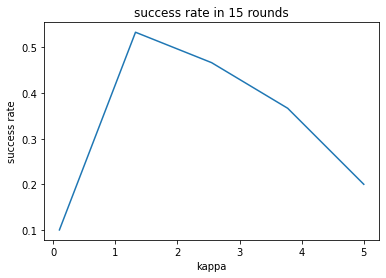

In [66]:
plt.bar(kappas, succ_rates)
plt.xlabel("kappa")
plt.ylabel("success rate")
plt.title("success rate in 15 rounds")
plt.savefig("15 trial succ_rate.png")
plt.show()

100%|██████████| 30/30 [00:24<00:00,  1.20it/s]


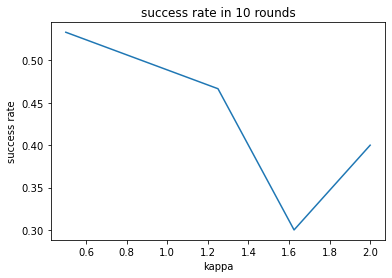

In [67]:
succ_rates = []
kappas = np.linspace(0.5, 2, 5)
for kappa in kappas:
    succ_rate = trial2(30, n_iter = 10, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    
plt.plot(kappas, succ_rates)
plt.xlabel("kappa")
plt.ylabel("success rate")
plt.title("success rate in 10 rounds")
plt.savefig("10 trial succ_rate narrow.png")
plt.show()

100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


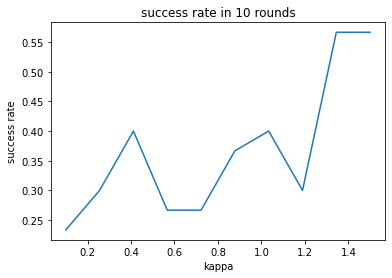

In [68]:
succ_rates = []
kappas = np.linspace(0.1, 1.5, 10)
for kappa in kappas:
    succ_rate = trial2(30, n_iter = 10, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    
plt.plot(kappas, succ_rates)
plt.xlabel("kappa")
plt.ylabel("success rate")
plt.title("success rate in 10 rounds")
plt.savefig("10 trial succ_rate more narrow.png")
plt.show()

100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


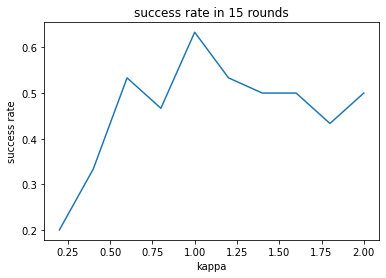

In [69]:
succ_rates = []
kappas = np.linspace(0.2, 2, 10)
for kappa in kappas:
    succ_rate = trial2(30, n_iter = 15, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    
plt.plot(kappas, succ_rates)
plt.xlabel("kappa")
plt.ylabel("success rate")
plt.title("success rate in 15 rounds")
plt.savefig("15 trial succ_rate narrow.png")
plt.show()

100%|██████████| 30/30 [00:51<00:00,  1.72s/it]


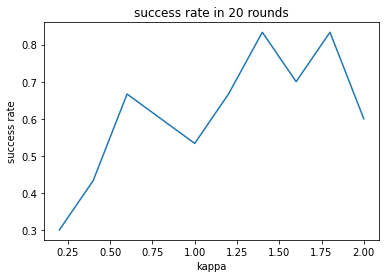

In [72]:
succ_rates = []
kappas = np.linspace(0.2, 2, 10)
for kappa in kappas:
    succ_rate = trial2(30, n_iter = 20, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    
plt.plot(kappas, succ_rates)
plt.xlabel("kappa")
plt.ylabel("success rate")
plt.title("success rate in 20 rounds")
plt.savefig("20 trial succ_rate narrow.png")
plt.show()

## Simple Trial

0.075


100%|██████████| 1/1 [00:03<00:00,  3.42s/it]

Best result: {'A': 102.06889102090035, 'B': 97.0, 'C': 125.84338618361845}; f(x) = 148.55273094936692.


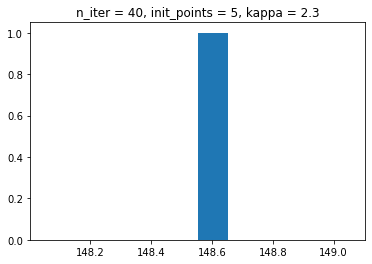

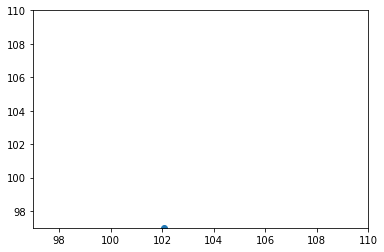

[148.55273094936692]


In [27]:
trial(1, n_iter = 40, init_points = 5, kappa = 2.3, verbose = 2)

## Making sure our method is better than random

0.15


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


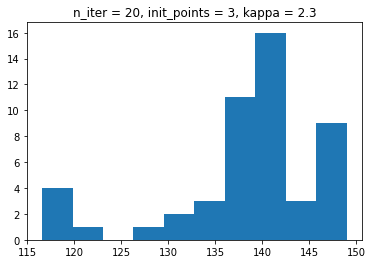

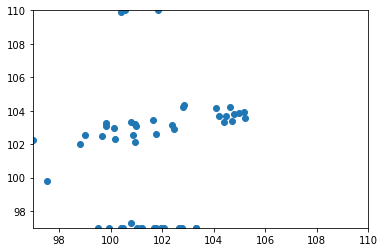

[148.94083564944438, 148.80293350364641, 148.7804308971855, 148.61935274479188, 148.5289763923368, 148.06598084149138, 147.3610279717895, 147.18976971171958, 146.12354362556522, 144.25024624162748, 144.16503568531775, 143.24215145174185, 142.11688556428263, 141.98421279567341, 141.95195399628514, 141.75233814055687, 141.7174072258657, 141.48947936664055, 141.4313743113626, 141.1477179354017, 140.93284751457222, 139.97523908717832, 139.8283615542519, 139.66094659998166, 139.559813644353, 139.51138930083158, 139.4664540436107, 139.4231859011972, 138.94542341598026, 138.9074443080565, 138.8313909321047, 138.41573296938373, 137.5484412884773, 137.17704228583517, 137.0977993685779, 137.0362716432221, 136.73680949978296, 136.3196606189075, 136.25613863503335, 134.8336208005396, 133.55256605120434, 133.32332391584293, 130.82741483238712, 130.45136029515473, 127.88148339534604, 122.8432345212318, 119.51880295288537, 119.51754923273327, 119.1022863528063, 116.58310008409707]


In [70]:
trial(50, n_iter = 20, init_points = 3, kappa = 2.3, verbose = 1)

0.15


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


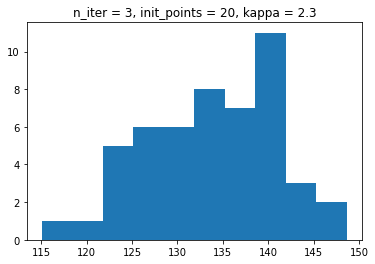

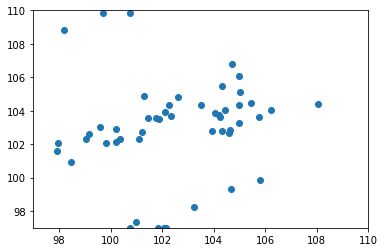

[148.60497691637062, 147.52605764966574, 143.732273991048, 142.60215145011867, 141.98159479291326, 141.71366977904802, 141.54859963840352, 141.11080600276279, 140.22492217340985, 140.18893667500285, 139.93188259992684, 139.52175289521378, 139.28884887333564, 139.13110441972145, 139.1045710218415, 138.7297493510525, 138.17503983630107, 138.065233726919, 138.05955279879643, 137.49961053169292, 137.20862789964204, 136.36644992189278, 135.33305042113108, 135.12793675987925, 134.2876222130726, 134.08161039952884, 133.99040448378582, 133.37358555525233, 132.91447823539238, 132.37739304666889, 132.0036048397521, 131.8356615123824, 131.31676482650772, 130.4700755409994, 130.23996218472954, 129.45132972319993, 128.9118316676865, 128.0993839529267, 126.92085663181928, 126.63022948419248, 126.6280477108036, 126.24890945709483, 125.38903932454623, 125.0258296095181, 124.16380024134672, 122.05308320945858, 121.97681730747395, 121.85899739558468, 120.6087233479306, 115.11346702958055]


In [71]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(50, n_iter = 3, init_points = 20, kappa = 2.3, verbose = 1)

## Trying out kappa

0.075


100%|██████████| 30/30 [01:09<00:00,  2.32s/it]


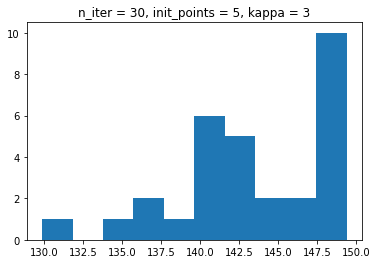

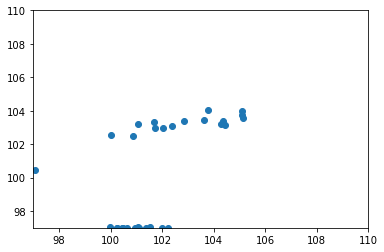

[149.3631698607996, 149.02039582949158, 148.80928451607556, 148.71781806324097, 148.56176148821743, 148.40669748155946, 148.07334488750806, 148.01046809464563, 147.81266801660888, 147.55227961954643, 147.1938491570696, 146.98017130193975, 144.04113051145976, 143.60616680147774, 142.7432635098593, 142.48675316207476, 142.3646378491598, 141.79442740863377, 141.67274023994247, 141.17588040593284, 140.96751257252566, 140.88103351672447, 140.57424233488092, 139.9578715226247, 139.71084571271712, 138.76833202371154, 136.76561936843973, 136.2076605841418, 134.83088441184807, 129.88621654598805]


In [30]:
trial(30, n_iter = 30, init_points = 5, kappa = 3, verbose = 1)

0.075


100%|██████████| 30/30 [01:09<00:00,  2.31s/it]


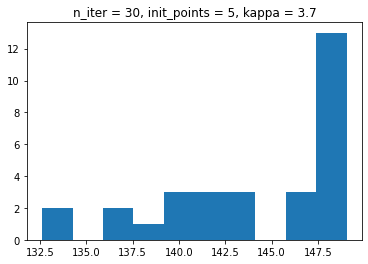

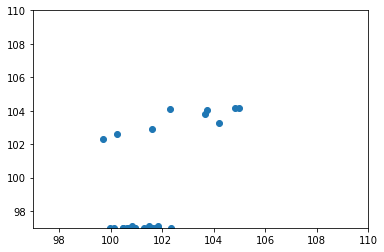

[149.04959388501413, 148.97561970299859, 148.9699326255163, 148.90883626609144, 148.78517130947588, 148.45972708382646, 148.417488686763, 148.16508949727452, 148.0965799392035, 147.65007465044806, 147.5727640046653, 147.51687107633796, 147.47111057676153, 147.1163349701911, 146.7115146968825, 146.2211415509408, 143.71355184953498, 143.5783425419136, 143.41366314975366, 142.15659222026508, 141.7820985000189, 141.03679578673294, 140.15050080919534, 139.9971343693523, 139.3146259620931, 138.66588971063678, 137.54028433930694, 136.83427403671624, 133.65944862828485, 132.6156224038479]


In [31]:
trial(30, n_iter = 30, init_points = 5, kappa = 3.7, verbose = 1)

0.005


100%|██████████| 30/30 [01:20<00:00,  2.69s/it]


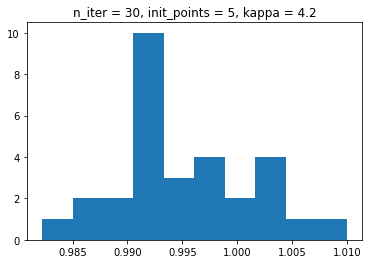

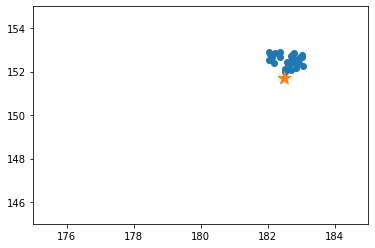

[1.0099275651075061, 1.0057432407079239, 1.0031714074141276, 1.0028285787529923, 1.0026152207791652, 1.0016914624359692, 1.00031013983553, 0.9996494411183863, 0.9986770665152287, 0.9969277307566085, 0.9968141596813636, 0.996336737903061, 0.9957287682640532, 0.9941436079836427, 0.9938991442101162, 0.9927801253840202, 0.9925087780288895, 0.9924450274435312, 0.9918306154596769, 0.9914860220989694, 0.991344979220506, 0.9913035019404713, 0.9911666277669351, 0.9911577838235325, 0.9911365890342339, 0.9900532272172319, 0.9889288623218873, 0.9877587255908526, 0.9871933822065762, 0.9822398620051983]


In [14]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 30/30 [01:20<00:00,  2.70s/it]


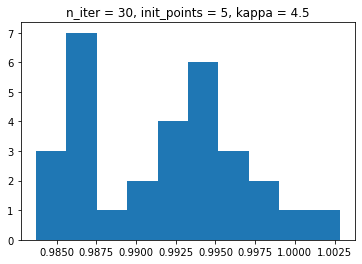

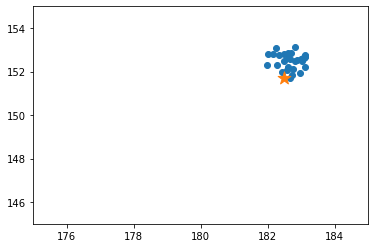

[1.002845496143244, 1.0003652682912207, 0.9981181859399981, 0.9977148677181087, 0.9967170052211959, 0.996322724474511, 0.9958723311851332, 0.9949221158611086, 0.994517539938718, 0.9945106246821662, 0.9944773642023491, 0.994319408487423, 0.9935273096349966, 0.9929989724649634, 0.9928331850304872, 0.9919169689871172, 0.9916141091588606, 0.9910507490832554, 0.9895429729944599, 0.9880299252317568, 0.9875220095190874, 0.9874742181975683, 0.9874377617748518, 0.9874251784310906, 0.9872578224555574, 0.9869105420069908, 0.9856624764225662, 0.9853672303131711, 0.9837846092369049, 0.983694691880906]


In [15]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.5, verbose = 1)

## Increase n_iter

0.005


100%|██████████| 30/30 [04:09<00:00,  8.33s/it]


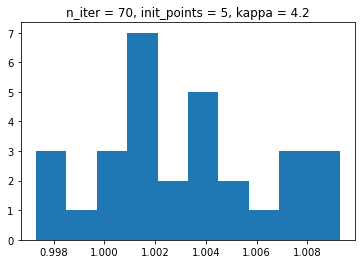

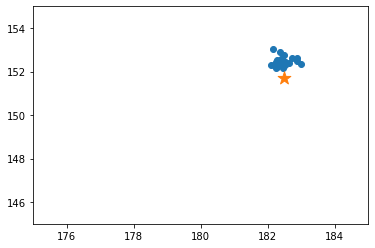

[1.009293574262792, 1.00854108503846, 1.0081116780782353, 1.0073653585771458, 1.007308336493777, 1.0070796605675907, 1.0065207769763043, 1.0056238980182735, 1.005160058478698, 1.0044496722805714, 1.003857308497389, 1.0038032306274174, 1.0037887226217377, 1.0036328893939248, 1.0029714977042912, 1.0025183811028833, 1.0020936628954877, 1.001932230316866, 1.001930790520646, 1.001800519640485, 1.0014782367575785, 1.0014444229217077, 1.0013938859080505, 1.000831254078408, 1.0006156686199872, 1.0004218900180861, 0.9988406972230829, 0.9982766537864265, 0.9980892407415828, 0.9972994642454442]


In [16]:
trial(30, n_iter = 70, init_points = 5, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 30/30 [04:13<00:00,  8.45s/it]


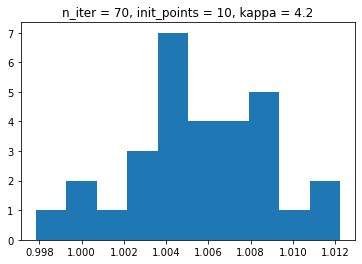

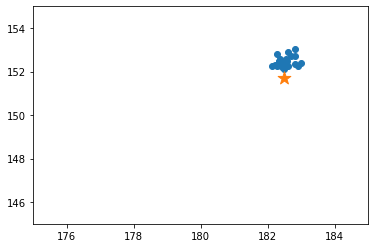

[1.0122385549118398, 1.0119465915401302, 1.0096966977720352, 1.008905075508967, 1.0088612013902272, 1.0086397049951552, 1.008136002043193, 1.0079193250155458, 1.007351400303183, 1.0072418881836172, 1.0071621294723168, 1.006529488897017, 1.0063399710984506, 1.006226174675893, 1.0055827571396603, 1.005454739684882, 1.0048662279793787, 1.0046184231942212, 1.0039759710297589, 1.0039423711758202, 1.0038993993608298, 1.0038227961776012, 1.0036740468306666, 1.0033662431549166, 1.0033395703268706, 1.0023953392763503, 1.0008931232611986, 1.0005222128422517, 0.9994321917441673, 0.997825126119587]


In [17]:
trial(30, n_iter = 70, init_points = 10, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 30/30 [17:21<00:00, 34.72s/it] 


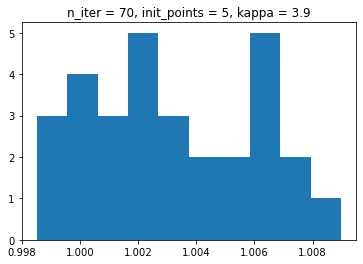

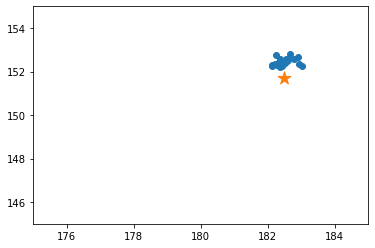

[1.0089826652165388, 1.0078269633320995, 1.0070100890310352, 1.006813438290966, 1.00680001035499, 1.0066894756569846, 1.0065500675557248, 1.006224694779767, 1.00554872500367, 1.005107788502952, 1.004457127507752, 1.0044389330426935, 1.0034164868202742, 1.0033953130713134, 1.003304547654519, 1.00256644312149, 1.0019328937303102, 1.0018770691073249, 1.0018555230482664, 1.0018442233188143, 1.001165400863245, 1.0010130942226194, 1.0007535976824706, 1.0004242367609768, 1.0003104977998893, 1.0000285063205705, 1.0000100989492129, 0.9994977384362354, 0.9988042698896549, 0.9985207799495563]


In [18]:
trial(30, n_iter = 70, init_points = 5, kappa = 3.9, verbose = 1)

# Try to decrease n_iter but do more trials. Fix kappa at 4.2

0.005


100%|██████████| 100/100 [16:15<00:00,  9.75s/it] 


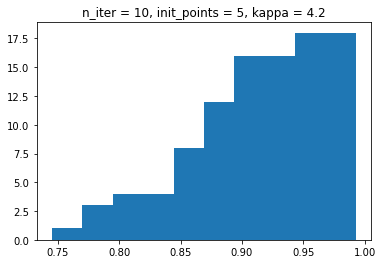

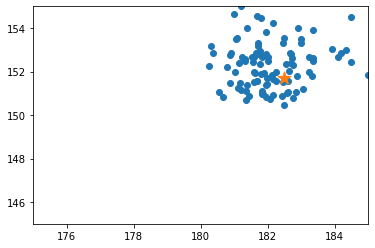

[0.9929722327915513, 0.9914993567628649, 0.9874754744072455, 0.9818312879942486, 0.9818032836564299, 0.9803936209937869, 0.9803545539936919, 0.9797571643773713, 0.9779856145629825, 0.9757335097450743, 0.9750621224342969, 0.9738929093604025, 0.9727706063578827, 0.9721919190870681, 0.9702713722826675, 0.9698364159627699, 0.9692075189543565, 0.9685272952777073, 0.9652060827910705, 0.9620969434551981, 0.9617717350735955, 0.9609786540867589, 0.9609160449711152, 0.9592278339378619, 0.9590209962861906, 0.9573243018088926, 0.957099390144514, 0.9547158626635077, 0.9545591730931141, 0.9536528756492069, 0.9533278341841079, 0.9513027318265548, 0.9504245706641448, 0.9494252806262522, 0.9492971134217422, 0.9478867524979436, 0.9407688150723967, 0.9404876862359139, 0.936343301825107, 0.9359041917796045, 0.9337057658851066, 0.9301692095607816, 0.9299600874180243, 0.9293691956384822, 0.9286818701266015, 0.9273732711102151, 0.9268433064210522, 0.9263461568486779, 0.9224224440988753, 0.9221517724341541, 0

In [19]:
trial(100, n_iter = 10, init_points = 5, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 100/100 [49:21<00:00, 29.62s/it]  


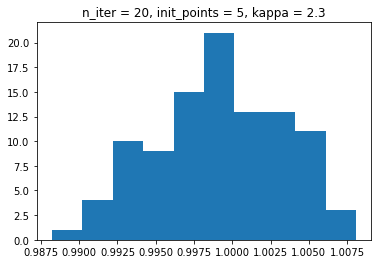

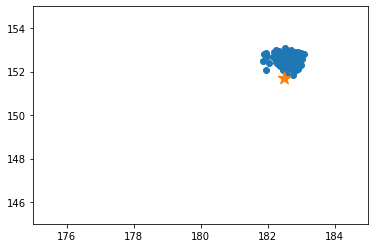

[1.0080909546510033, 1.0070153289602672, 1.00622651705912, 1.005699744770563, 1.0055357896397807, 1.005304494410228, 1.0052078195920826, 1.0051946226098187, 1.0049649310761979, 1.0048042373471815, 1.0046745883230148, 1.0045433451903238, 1.0043106405240785, 1.0041289800764366, 1.003640466107231, 1.0034783601072914, 1.0031536713974583, 1.0030506667577161, 1.0030455619968348, 1.002970425691048, 1.00296805966387, 1.002814611257397, 1.002689404496814, 1.0025248845105201, 1.0025152523478025, 1.0025057719472834, 1.002144844839386, 1.0020477639076404, 1.0020260214983079, 1.0020036217368604, 1.001889940427339, 1.0016182104443832, 1.00144246064671, 1.0014331450392675, 1.0012851606220674, 1.0012786654877628, 1.0008296505028595, 1.0006674108662466, 1.0004948220496042, 1.0001907970886896, 1.0000381741148683, 0.9997487917414005, 0.9996875550796518, 0.9996306847425719, 0.9994844039956924, 0.9993922807341254, 0.9992485712615449, 0.9990946198056755, 0.9990683150280854, 0.9989366129544824, 0.99881863114

In [20]:
trial(100, n_iter = 20, init_points = 5, kappa = 2.3, verbose = 1)

0.005


100%|██████████| 100/100 [1:01:22<00:00, 36.83s/it]


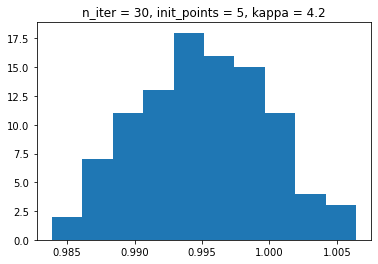

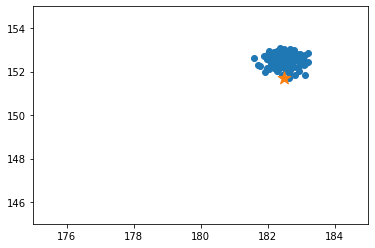

[1.006434459358759, 1.005537595176266, 1.0050746533452992, 1.003788011260399, 1.003160182804496, 1.0025953046127496, 1.0021115551973916, 1.001798893174795, 1.0017656962615422, 1.0016992357869494, 1.0011535991702631, 1.0008921403293565, 1.0007593815618487, 1.000227083380669, 1.0000874063081016, 0.9999476339087682, 0.9998735160924646, 0.9997826040664639, 0.9996360891665744, 0.9995908162250728, 0.9991285461613233, 0.9987778214172848, 0.9987418695317455, 0.9986030678186482, 0.9984196847560289, 0.9982555888087598, 0.9982481563567625, 0.9981292648193024, 0.9981186938596698, 0.9978188564827901, 0.997808859996711, 0.9978050005996693, 0.9977458644268049, 0.9973811431331477, 0.9973708363812048, 0.997217008408601, 0.9970129978819287, 0.996895800696667, 0.9968668807253371, 0.9968402510440484, 0.9968329013131598, 0.9967110402597659, 0.996643590755654, 0.9961947351519003, 0.9960774558036163, 0.9958150485569617, 0.9957777646490997, 0.995731156740502, 0.9955674105542153, 0.9946011669177659, 0.99459342

In [21]:
trial(100, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1)

0.005


100%|██████████| 100/100 [1:38:15<00:00, 58.95s/it]  


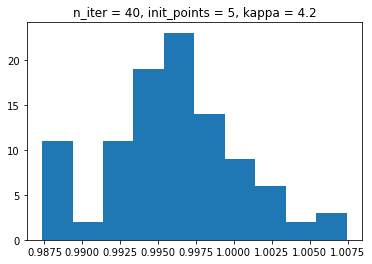

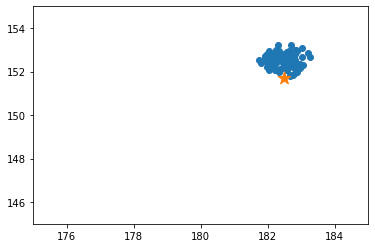

[1.0074335796649376, 1.0066761965774793, 1.005442455007923, 1.0045916192817286, 1.0036223397017885, 1.003280400213643, 1.0031280370491062, 1.0028029457416143, 1.002396541453467, 1.001773966023372, 1.0016015816553456, 1.0008708892900864, 1.0007697870725498, 1.0007334225694222, 1.0004587921055197, 1.0004359202135573, 1.0003281820242629, 0.9999351288125151, 0.9998532463783529, 0.9997712705971518, 0.9993754275046787, 0.9993674803456585, 0.9992587969913796, 0.9990428966361248, 0.9988979007502891, 0.9986098739323124, 0.9982167387081532, 0.9981641287402772, 0.998157040898865, 0.998053668331953, 0.99784090922202, 0.9977803353015677, 0.9974960888222992, 0.9974724650240281, 0.9973325212142988, 0.9972865087932961, 0.9972382732679044, 0.9971395391273858, 0.9970732201440959, 0.996943755440618, 0.9968912702812438, 0.996883200374368, 0.9967745517539978, 0.9964531299992194, 0.9963006549736956, 0.9962766133433174, 0.996247080280264, 0.9961872852428211, 0.9961053734949346, 0.9960923595328742, 0.99604599

In [22]:
trial(100, n_iter = 40, init_points = 5, kappa = 4.2, verbose = 1)

# Best parameters: kappa = 4.2, n_iter = 40

In [23]:
# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}

def venus_opt(venus:Venus):
    venus.
venus_opt(1)

SyntaxError: invalid syntax (<ipython-input-23-379e0b5c32fa>, line 11)

In [ ]:
# TODO: guide optimization to known good points
# TODO: modify the loss function to have larger differences between global min and local min
# TODO: find a way to set halting condition or use a different library

In [ ]:
# unused. Potentially for future tests
# from deap import benchmarks

# def ackley_arg0(sol):
#     return benchmarks.ackley(sol)[0]

In [ ]:
# ackley_arg0((0,0,0))

In [ ]:
# Global min: (182.5, 151.7, 140.0) value
# TODO: use get current function
# scikit optimization
# skopt2